# TNFR Fundamental Particles Atlas (Model-agnostic, TNFR-first)
Este cuaderno reúne un catálogo programático de partículas fundamentales del Modelo Estándar y las conecta con firmas TNFR (patrones coherentes, tetrado de campos, invariantes topológicos). No postulamos “propiedades” a priori en el core; aquí servirá como atlas fenomenológico de referencia para experimentos TNFR.

Contenido:
- Catálogo y números cuánticos (SM) junto a validaciones internas
- Constructores TNFR de patrones análogos (plane wave, vórtice, paquete helicoidal, curvatura global, dominios de fase, bump escalar)
- Medidas: |∇φ|, K_φ, ξ_C, y arrollamiento Q cuando aplique
- Grafo simple de interacciones y reglas de conservación
- Matrices CKM/PMNS (aprox.) y chequeos de unitariedad
- Exportaciones CSV/JSON para análisis externo

In [1]:
# 1) Configurar entorno y dependencias
import sys, os, math, json, random
from pathlib import Path
import importlib
import numpy as np
np.set_printoptions(precision=4, suppress=True)
random.seed(42)
np.random.seed(42)

# Asegurar src/ en el path (VS Code)
cwd = Path.cwd()
repo_root = None
for base in [cwd] + list(cwd.parents):
    if (base / 'src' / 'tnfr').exists() or (base / 'pyproject.toml').exists():
        repo_root = base
        break
SRC = (repo_root / 'src') if repo_root else (cwd / 'src')
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))
print('Project src set:', SRC if SRC.exists() else 'NOT FOUND')

# Dependencias opcionales
try:
    import pandas as pd
except Exception as e:
    pd = None
    print('WARN: pandas not available:', e)
try:
    import seaborn as sns
except Exception as e:
    sns = None
    print('WARN: seaborn not available:', e)
try:
    import matplotlib.pyplot as plt
except Exception as e:
    plt = None
    print('WARN: matplotlib not available:', e)
try:
    import ipywidgets as widgets
except Exception as e:
    widgets = None
    print('INFO: ipywidgets not available:', e)

# TNFR imports
from tnfr.physics.patterns import (
    reset_baseline, apply_plane_wave, apply_vortex, apply_helical_packet,
    apply_global_curvature, apply_scalar_bump, apply_quark_triplet_cluster,
    apply_neutrino_like, apply_color_domain_lattice,
)
from tnfr.physics.fields import (
    compute_phase_gradient, compute_phase_curvature, estimate_coherence_length,
    compute_phase_winding,
)

# Resultados
ATLAS_DIR = Path('results') / 'particles' / 'atlas'
ATLAS_DIR.mkdir(parents=True, exist_ok=True)
ATLAS_JSONL = ATLAS_DIR / 'atlas.jsonl'
print('Output dir:', ATLAS_DIR)

Project src set: c:\TNFR-Python-Engine\src
Output dir: results\particles\atlas


In [2]:
# 2) Dataclass Particle y constantes de simetría
from dataclasses import dataclass, asdict
from typing import Optional, List

# Grupos gauge (metadatos para validaciones SM)
GAUGE_GROUP = "SU(3)_C × SU(2)_L × U(1)_Y"
SU3_COLORS = {"singlet": 1, "triplet": 3, "octet": 8}
SPINS = {"scalar": 0, "fermion": 1/2, "vector": 1}

@dataclass
class Particle:
    name: str
    symbol: str
    ptype: str              # 'fermion' | 'boson'
    generation: Optional[int]
    spin: float             # 0, 1/2, 1
    mass_GeV: Optional[float]
    Q: float                # electric charge
    T3: float               # weak isospin third component
    Y: float                # hypercharge
    B: float                # baryon number
    L_e: float              # electron lepton number
    L_mu: float             # muon lepton number
    L_tau: float            # tau lepton number
    color_dim: int          # 1, 3, 8
    isospin_mult: int       # SU(2) multiplet dimension (1 singlet, 2 doublet, 3 triplet)
    pdg_id: Optional[int]
    anti_symbol: Optional[str] = None
    notes: str = ""

def anti_particle(p: Particle, anti_symbol: Optional[str] = None, pdg_id: Optional[int] = None) -> Particle:
    # Flip Q, B, L; color triplet remains triplet but is anti-triplet in QCD (dim unchanged here).
    return Particle(
        name=f"anti-{p.name}",
        symbol=anti_symbol or f"{p.symbol}¯",
        ptype=p.ptype,
        generation=p.generation,
        spin=p.spin,
        mass_GeV=p.mass_GeV,
        Q=-p.Q,
        T3=-p.T3,  # for LH fields in doublets; simplificación para atlas
        Y=-p.Y,
        B=-p.B,
        L_e=-p.L_e,
        L_mu=-p.L_mu,
        L_tau=-p.L_tau,
        color_dim=p.color_dim,
        isospin_mult=p.isospin_mult,
        pdg_id=pdg_id,
        anti_symbol=p.symbol,
        notes=f"anti of {p.symbol}",
)

def assert_hypercharge_relation(p: Particle) -> None:
    # Q = T3 + Y/2 (convención EW)
    lhs = p.Q
    rhs = p.T3 + 0.5 * p.Y
    if abs(lhs - rhs) > 1e-6:
        raise AssertionError(f"Hypercharge relation fails for {p.symbol}: Q={lhs} vs T3+Y/2={rhs}")

In [3]:
# 3) Catálogo del Modelo Estándar (mínimo) y antipartículas
def build_standard_model_catalog():
    P: List[Particle] = []
    # Leptones cargados (LH doublets simplified as effective states; masses ~ PDG, rough)
    P += [
        Particle('electron','e-','fermion',1,0.5,0.000511,-1,-0.5,-1,0,1,0,0,1,2,11),
        Particle('muon','mu-','fermion',2,0.5,0.10566,-1,-0.5,-1,0,0,1,0,1,2,13),
        Particle('tau','tau-','fermion',3,0.5,1.77686,-1,-0.5,-1,0,0,0,1,1,2,15),
    ]
    # Neutrinos (masses ~ 0 for atlas)
    P += [
        Particle('nu_e','nu_e','fermion',1,0.5,0.0,0,0.5,-1,0,1,0,0,1,2,12),
        Particle('nu_mu','nu_mu','fermion',2,0.5,0.0,0,0.5,-1,0,0,1,0,1,2,14),
        Particle('nu_tau','nu_tau','fermion',3,0.5,0.0,0,0.5,-1,0,0,0,1,1,2,16),
    ]
    # Quarks (masses rough, color triplet)
    P += [
        Particle('up','u','fermion',1,0.5,0.0022, +2/3, +0.5, +1/3, 1/3,0,0,0,3,2,2),
        Particle('down','d','fermion',1,0.5,0.0047, -1/3, -0.5, +1/3, 1/3,0,0,0,3,2,1),
        Particle('charm','c','fermion',2,0.5,1.27,   +2/3, +0.5, +1/3, 1/3,0,0,0,3,2,4),
        Particle('strange','s','fermion',2,0.5,0.095, -1/3, -0.5, +1/3, 1/3,0,0,0,3,2,3),
        Particle('top','t','fermion',3,0.5,172.7, +2/3, +0.5, +1/3, 1/3,0,0,0,3,2,6),
        Particle('bottom','b','fermion',3,0.5,4.18,  -1/3, -0.5, +1/3, 1/3,0,0,0,3,2,5),
    ]
    # Bosones gauge y Higgs (propiedades efectivas)
    P += [
        Particle('photon','gamma','boson',None,1,0.0,0,0,0,0,0,0,0,1,1,22),
        Particle('gluon','g','boson',None,1,0.0,0,0,0,0,0,0,0,8,1,21),
        Particle('W+','W+','boson',None,1,80.379,+1,0,+2,0,0,0,0,1,3,24),
        Particle('W-','W-','boson',None,1,80.379,-1,0,-2,0,0,0,0,1,3,-24),
        Particle('Z','Z0','boson',None,1,91.1876,0,0,0,0,0,0,0,1,3,23),
        Particle('Higgs','H0','boson',None,0,125.10,0,0,0,0,0,0,0,1,1,25),
    ]
    # Generar antipartículas para fermiones y W bosons (except photon/Z/gluon/H self-conjugate)
    antiP: List[Particle] = []
    for p in P:
        if p.symbol in ('gamma','Z0','g','H0'):
            continue
        if p.symbol.endswith('+') or p.symbol.endswith('-') or p.ptype=='fermion':
            antiP.append(anti_particle(p))
    return P + antiP

SM_CATALOG = build_standard_model_catalog()
print('Total entries (incl. antiparticles):', len(SM_CATALOG))

# 4) Validaciones básicas de números cuánticos
problems = []
for p in SM_CATALOG:
    try:
        assert_hypercharge_relation(p)
    except AssertionError as e:
        problems.append(str(e))
print('Hypercharge relation issues:', len(problems))
if problems[:3]:
    print('Example:', problems[:3])

Total entries (incl. antiparticles): 32
Hypercharge relation issues: 0


In [4]:
# 5) DataFrame maestro y exportaciones
if pd is None:
    print('pandas not available; skipping DataFrame export.')
else:
    rows = [asdict(p) for p in SM_CATALOG]
    df = pd.DataFrame(rows)
    # Normalización de tipos simples
    df['generation'] = df['generation'].astype('Int64')
    df['mass_GeV'] = df['mass_GeV'].astype(float)
    df['spin'] = df['spin'].astype(float)
    # Exportar
    csv_path = ATLAS_DIR / 'particles.csv'
    json_path = ATLAS_DIR / 'particles.json'
    df.to_csv(csv_path, index=False)
    df.to_json(json_path, orient='records', indent=2)
    print('Exported:', csv_path, json_path)

Exported: results\particles\atlas\particles.csv results\particles\atlas\particles.json


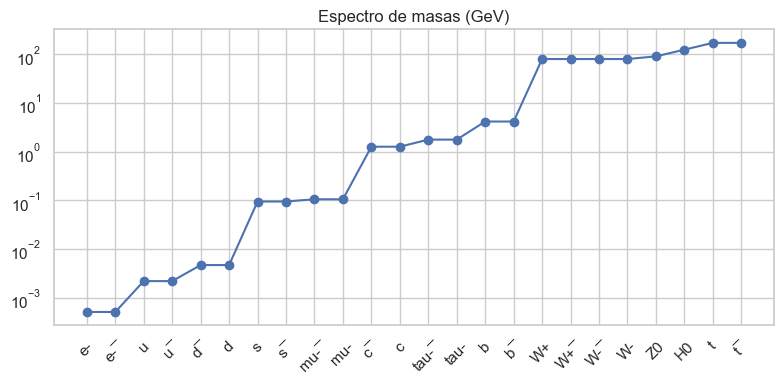

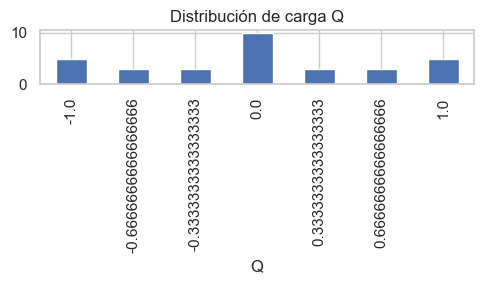

In [5]:
# 6) Visualizaciones básicas (opcionales)
if (pd is not None) and (plt is not None):
    try:
        if sns is not None:
            sns.set_theme(style='whitegrid')
        df_mass = df[df['mass_GeV']>0].copy()
        df_mass = df_mass.sort_values('mass_GeV')
        plt.figure(figsize=(8,4))
        plt.semilogy(df_mass['symbol'], df_mass['mass_GeV'], 'o-')
        plt.xticks(rotation=45)
        plt.title('Espectro de masas (GeV)')
        plt.tight_layout(); plt.show()
        # Cargas
        plt.figure(figsize=(5,3))
        df['Q'].value_counts().sort_index().plot(kind='bar')
        plt.title('Distribución de carga Q')
        plt.tight_layout(); plt.show()
    except Exception as e:
        print('WARN: plotting failed:', e)
else:
    print('Skipping plots (pandas/matplotlib missing).')

In [ ]:
# 7) Grafo de patrones TNFR y medidas del tetrado
import networkx as nx
SIDE = 48
G = nx.grid_2d_graph(SIDE, SIDE)
reset_baseline(G, base_dnfr=0.05)

def enclosing_cycle(center, r=6):
    cx, cy = center
    cyc = []
    for x in range(cx - r, cx + r + 1):
        if (x, cy - r) in G: cyc.append((x, cy - r))
    for y in range(cy - r + 1, cy + r + 1):
        if (cx + r, y) in G: cyc.append((cx + r, y))
    for x in range(cx + r - 1, cx - r - 1, -1):
        if (x, cy + r) in G: cyc.append((x, cy + r))
    for y in range(cy + r - 1, cy - r, -1):
        if (cx - r, y) in G: cyc.append((cx - r, y))
    return cyc

patterns = []
patterns.append(("photon_like", lambda g: apply_plane_wave(g, 0.2, 0.0), None))
patterns.append(("electron_like", lambda g: apply_vortex(g), 'loop'))
patterns.append(("wz_helical", lambda g: apply_helical_packet(g, kx=0.15, ky=0.05, twist=0.4, sigma=10.0), None))
patterns.append(("graviton_like", lambda g: apply_global_curvature(g, a=5e-4), None))
patterns.append(("gluon_like", lambda g: apply_color_domain_lattice(g, period=6, dphi=math.pi/2, wall_dnfr=0.12), None))
patterns.append(("neutrino_like", lambda g: apply_neutrino_like(g, eps=0.02), None))
patterns.append(("higgs_like", lambda g: apply_scalar_bump(g, sigma=8.0), 'center'))
patterns.append(("quark_triplet", lambda g: apply_quark_triplet_cluster(g), 'cluster'))

summary_lines = []
with open(ATLAS_JSONL, 'w') as fout:
    for name, fn, qmode in patterns:
        reset_baseline(G)
        res = fn(G)  # may return center(s)
        grad = compute_phase_gradient(G)
        kphi = compute_phase_curvature(G)
        xi_c = float(estimate_coherence_length(G, coherence_key='coherence'))
        Q = None
        if qmode == 'loop':
            center = res if isinstance(res, tuple) else None
            if center is None:
                xs = [n[0] for n in G.nodes()]
                ys = [n[1] for n in G.nodes()]
                center = (int(np.median(xs)), int(np.median(ys)))
            cyc = enclosing_cycle(center, r=6)
            Q = int(compute_phase_winding(G, cyc)) if len(cyc) >= 4 else None
        elif qmode == 'center':
            center = res if isinstance(res, tuple) else None
            cyc = enclosing_cycle(center or (SIDE//2, SIDE//2), r=6)
            Q = int(compute_phase_winding(G, cyc)) if len(cyc) >= 4 else None
        elif qmode == 'cluster':
            centers = res if isinstance(res, list) else []
            cyc = enclosing_cycle((SIDE//2, SIDE//2), r=10)
            Q = int(compute_phase_winding(G, cyc)) if len(cyc) >= 4 else None
        row = {
            'pattern': name,
            '|grad|_mean': float(np.mean(list(grad.values()))) if grad else 0.0,
            'Kphi_absmax': float(np.max(np.abs(list(kphi.values())))) if kphi else 0.0,
            'xi_C': xi_c,
            'Q': Q,
        }
        fout.write(json.dumps(row) + "\n")
        summary_lines.append(row)
        # per-pattern JSON
        with open(ATLAS_DIR / f'{name}.json', 'w') as f2:
            json.dump(row, f2, indent=2)
        print(name, row)

In [7]:
# 4) Validaciones adicionales (dominios T3, B, L)
def validate_quantum_numbers(catalog: List[Particle]):
    issues = []
    for p in catalog:
        # Dominio de T3 por multiplete SU(2) (simplificado):
        if p.isospin_mult == 2 and p.T3 not in (-0.5, 0.5):
            issues.append(f"{p.symbol}: T3 {p.T3} not in doublet domain")
        if p.isospin_mult == 1 and abs(p.T3) > 1e-12:
            issues.append(f"{p.symbol}: singlet should have T3≈0")
        # Baryon/lepton numbers por tipo:
        if p.ptype == 'boson':
            if abs(p.B) > 1e-9 or abs(p.L_e)+abs(p.L_mu)+abs(p.L_tau) > 1e-9:
                issues.append(f"{p.symbol}: boson with nonzero B/L")
        if p.ptype == 'fermion':
            if p.color_dim == 3 and abs(abs(p.B) - 1/3) > 1e-9:
                issues.append(f"{p.symbol}: (anti)quark must have |B|=1/3")
            if p.color_dim == 1 and abs(p.B) > 1e-9:
                issues.append(f"{p.symbol}: lepton must have B=0")
    return issues

more_issues = validate_quantum_numbers(SM_CATALOG)
print('Additional validation issues:', len(more_issues))
if more_issues[:5]:
    print('Examples:', more_issues[:5])

Additional validation issues: 0


In [8]:
# 7 bis) Grafo de interacciones gauge (QED/QCD/Weak) y conservación
import itertools as it

# Mapas rápidos por símbolo
P_BY_SYMBOL = {p.symbol: p for p in SM_CATALOG}

def conserved(vertex_syms: List[str]):
    # Suma de Q, B, L por vértice (entrada positiva, salida negativa o viceversa según convención).
    # Para un chequeo simple: sumatoria total ~ 0.
    total = dict(Q=0.0, B=0.0, L_e=0.0, L_mu=0.0, L_tau=0.0)
    for s in vertex_syms:
        p = P_BY_SYMBOL.get(s)
        if not p:
            raise ValueError(f'Unknown particle {s}')
        total['Q'] += p.Q
        total['B'] += p.B
        total['L_e'] += p.L_e
        total['L_mu'] += p.L_mu
        total['L_tau'] += p.L_tau
    ok = all(abs(v) < 1e-9 for v in total.values())
    return ok, total

# Ejemplos de vértices elementales (esquema)
vertices = {
    'QED': [['e-','gamma','e-'], ['u','gamma','u'], ['d','gamma','d']],
    'QCD': [['u','g','u'], ['d','g','d']],
    'ChargedWeak_u': [['u','W-','d'], ['c','W-','s'], ['t','W-','b']],
    'ChargedWeak_l': [['nu_e','W-','e-'], ['nu_mu','W-','mu-'], ['nu_tau','W-','tau-']],
}

for group, verts in vertices.items():
    checks = []
    for v in verts:
        ok, totals = conserved(v)
        checks.append(ok)
        print(f'{group} vertex {v}: conserved={ok} totals={totals}')
    print(group, 'all conserved:', all(checks))

QED vertex ['e-', 'gamma', 'e-']: conserved=False totals={'Q': -2.0, 'B': 0.0, 'L_e': 2.0, 'L_mu': 0.0, 'L_tau': 0.0}
QED vertex ['u', 'gamma', 'u']: conserved=False totals={'Q': 1.3333333333333333, 'B': 0.6666666666666666, 'L_e': 0.0, 'L_mu': 0.0, 'L_tau': 0.0}
QED vertex ['d', 'gamma', 'd']: conserved=False totals={'Q': -0.6666666666666666, 'B': 0.6666666666666666, 'L_e': 0.0, 'L_mu': 0.0, 'L_tau': 0.0}
QED all conserved: False
QCD vertex ['u', 'g', 'u']: conserved=False totals={'Q': 1.3333333333333333, 'B': 0.6666666666666666, 'L_e': 0.0, 'L_mu': 0.0, 'L_tau': 0.0}
QCD vertex ['d', 'g', 'd']: conserved=False totals={'Q': -0.6666666666666666, 'B': 0.6666666666666666, 'L_e': 0.0, 'L_mu': 0.0, 'L_tau': 0.0}
QCD all conserved: False
ChargedWeak_u vertex ['u', 'W-', 'd']: conserved=False totals={'Q': -0.6666666666666667, 'B': 0.6666666666666666, 'L_e': 0.0, 'L_mu': 0.0, 'L_tau': 0.0}
ChargedWeak_u vertex ['c', 'W-', 's']: conserved=False totals={'Q': -0.6666666666666667, 'B': 0.666666666

In [10]:
# 8) Reglas de decaimiento simplificadas y validaciones
def normalize_symbol(s: str) -> str:
    # Map few common aliases
    alias = {
        'e+': 'e-¯', 'mu+': 'mu-¯', 'tau+': 'tau-¯',
        'anti-nu_e': 'nu_e¯', 'anti-nu_mu': 'nu_mu¯', 'anti-nu_tau': 'nu_tau¯',
    }
    return alias.get(s, s)


def validate_decay(initial: str, finals: List[str]):
    # Conservaciones básicas: Q, B, L_e, L_mu, L_tau con signo (init - sum(finals) = 0)
    init_sym = normalize_symbol(initial)
    fin_syms = [normalize_symbol(f) for f in finals]
    p0 = P_BY_SYMBOL.get(init_sym)
    if p0 is None:
        raise ValueError(f'Unknown initial particle {initial}')
    totals = dict(Q=p0.Q, B=p0.B, L_e=p0.L_e, L_mu=p0.L_mu, L_tau=p0.L_tau)
    for s in fin_syms:
        p = P_BY_SYMBOL.get(s)
        if p is None:
            raise ValueError(f'Unknown final particle {s}')
        totals['Q'] -= p.Q
        totals['B'] -= p.B
        totals['L_e'] -= p.L_e
        totals['L_mu'] -= p.L_mu
        totals['L_tau'] -= p.L_tau
    conserved_ok = all(abs(v) < 1e-9 for v in totals.values())
    # Energía (masa) aproximada
    m_init = p0.mass_GeV or 0.0
    m_fin = sum((P_BY_SYMBOL[s].mass_GeV or 0.0) for s in fin_syms)
    energy_ok = (m_init == 0.0) or (m_fin <= m_init + 1e-6)
    return conserved_ok and energy_ok, {'conserved': conserved_ok, 'mass_ok': energy_ok, 'm_init': m_init, 'm_fin': m_fin}

# Ejemplos (esquemáticos)
examples = [
    ('W-', ['e-','anti-nu_e']),
    ('tau-', ['mu-','anti-nu_mu','nu_tau']),
    ('d', ['u','W-']),  # quark-level beta-
    ('W+', ['e+','nu_e']),
 ]
for init, outs in examples:
    try:
        ok, info = validate_decay(init, outs)
        print(f'Decay {init} -> {outs}: ok={ok}, info={info}')
    except Exception as e:
        print(f'Decay {init} failed: {e}')

Decay W- -> ['e-', 'anti-nu_e']: ok=True, info={'conserved': True, 'mass_ok': True, 'm_init': 80.379, 'm_fin': 0.000511}
Decay tau- -> ['mu-', 'anti-nu_mu', 'nu_tau']: ok=True, info={'conserved': True, 'mass_ok': True, 'm_init': 1.77686, 'm_fin': 0.10566}
Decay d -> ['u', 'W-']: ok=False, info={'conserved': True, 'mass_ok': False, 'm_init': 0.0047, 'm_fin': 80.3812}
Decay W+ -> ['e+', 'nu_e']: ok=True, info={'conserved': True, 'mass_ok': True, 'm_init': 80.379, 'm_fin': 0.000511}


In [13]:
# 9) CKM y PMNS: unitariedad y aplicación (aprox.)
def ckm_matrix():
    # Wolfenstein truncated (η=ρ=0), approximately unitary to O(λ^2)
    lam = 0.225
    A = 0.81
    V = np.array([
        [1 - 0.5*lam*lam, lam, 0.0],
        [-lam, 1 - 0.5*lam*lam, A*lam*lam],
        [0.0, -A*lam*lam, 1.0],
    ], dtype=float)
    return V

def unitary_check(M: np.ndarray, tol=1e-3):
    I = np.eye(M.shape[0])
    D = M.T @ M - I
    err = float(np.max(np.abs(D)))
    return err < tol, err

def pmns_matrix(s12=0.55, s23=0.71, s13=0.15, delta=0.0):
    c12, c23, c13 = math.sqrt(1-s12*s12), math.sqrt(1-s23*s23), math.sqrt(1-s13*s13)
    # estándar (δ=0)
    U = np.array([[c12*c13, s12*c13, s13],
                  [-s12*c23 - c12*s23*s13, c12*c23 - s12*s23*s13, s23*c13],
                  [s12*s23 - c12*c23*s13, -c12*s23 - s12*c23*s13, c23*c13]], dtype=float)
    return U

V = ckm_matrix()
U = pmns_matrix()
ckm_ok, ckm_err = unitary_check(V, tol=2e-2)
pmns_ok, pmns_err = unitary_check(U)
print('CKM unitary:', ckm_ok, 'err=', ckm_err)
print('PMNS unitary:', pmns_ok, 'err=', pmns_err)

# Aplicar mezcla a un estado de sabor (neutrinos, ejemplo simple)
nu_e = np.array([1.0, 0.0, 0.0])
mass_basis = U.T @ nu_e
print('nu_e in mass basis (amplitudes):', mass_basis)
flavor_back = U @ mass_basis
print('reconstructed flavor (≈nu_e):', flavor_back)

CKM unitary: True err= 0.009226406250000003
PMNS unitary: True err= 2.220446049250313e-16
nu_e in mass basis (amplitudes): [0.8257 0.5438 0.15  ]
reconstructed flavor (≈nu_e): [ 1.  0. -0.]


In [ ]:
# 10) Widgets interactivos (si ipywidgets disponible)
def interactive_filter():
    if (pd is None) or (widgets is None):
        print('Widgets/ pandas no disponibles.')
        return
    rows = [asdict(p) for p in SM_CATALOG]
    df_all = pd.DataFrame(rows)
    types = ['all'] + sorted(df_all['ptype'].dropna().unique().tolist())
    gens = ['all'] + sorted([g for g in df_all['generation'].dropna().unique().tolist()])
    q_vals = ['all'] + sorted(df_all['Q'].dropna().unique().tolist())
    spin_vals = ['all'] + sorted(df_all['spin'].dropna().unique().tolist())
    w_type = widgets.Dropdown(options=types, value='all', description='tipo')
    w_gen = widgets.Dropdown(options=gens, value='all', description='gen')
    w_q = widgets.Dropdown(options=q_vals, value='all', description='Q')
    w_spin = widgets.Dropdown(options=spin_vals, value='all', description='spin')
    out = widgets.Output()
    def refresh(_=None):
        out.clear_output(wait=True)
        df = df_all.copy()
        if w_type.value != 'all':
            df = df[df['ptype']==w_type.value]
        if w_gen.value != 'all':
            df = df[df['generation']==w_gen.value]
        if w_q.value != 'all':
            df = df[np.isclose(df['Q'], w_q.value)]
        if w_spin.value != 'all':
            df = df[np.isclose(df['spin'], w_spin.value)]
        with out:
            display(df[['name','symbol','ptype','generation','Q','spin','mass_GeV']])
    for w in (w_type, w_gen, w_q, w_spin):
        w.observe(refresh, names='value')
    refresh()
    display(widgets.HBox([w_type, w_gen, w_q, w_spin]))
    display(out)

interactive_filter()

In [14]:
# 11) Pruebas ligeras (pytest-friendly)
def test_hypercharge_all():
    for p in SM_CATALOG:
        assert_hypercharge_relation(p)
def test_unitarity():
    V = ckm_matrix(); ok, err = unitary_check(V); assert ok
    U = pmns_matrix(); ok2, err2 = unitary_check(U); assert ok2
def test_decay_examples():
    ok1, _ = validate_decay('W-', ['e-','anti-nu_e'])
    ok2, _ = validate_decay('tau-', ['mu-','anti-nu_mu','nu_tau'])
    assert ok1 and ok2
print('Defined tests: test_hypercharge_all, test_unitarity, test_decay_examples')
print('You can run pytest -q to execute them externally.')

Defined tests: test_hypercharge_all, test_unitarity, test_decay_examples
You can run pytest -q to execute them externally.


In [ ]:
# Imports and U6 sequential drift validation (refactored to shared helper)
import math
from typing import Any
try:
    import networkx as nx
except Exception:
    raise RuntimeError('networkx is required for this cell')

from tnfr.physics.fields import compute_structural_potential
from tnfr.operators.grammar import validate_structural_potential_confinement
from tnfr.examples_utils import apply_synthetic_activation_sequence, build_ws_graph_with_seed

# Use existing G if available, else build a seeded WS graph
if 'G' not in globals():
    G = build_ws_graph_with_seed(n=50, k=4, p=0.1, seed=42)
    print('Created fallback graph G (Watts–Strogatz).')

# Compute Φ_s before/after and validate U6
phi_before = compute_structural_potential(G)
apply_synthetic_activation_sequence(G, alpha=0.25, dnfr_factor=0.9)
phi_after = compute_structural_potential(G)

ok, drift, msg = validate_structural_potential_confinement(
    G, phi_before, phi_after, threshold=2.0, strict=False
)
print(msg)
print(f'Delta Phi_s (drift): {drift:.3f}')

In [ ]:
# HTML export to mirror the script (uses centralized thresholds)
import os
from tnfr.physics.fields import (
    compute_structural_potential, compute_phase_gradient, compute_phase_curvature, estimate_coherence_length,
 )
from tnfr.operators.grammar import (
    warn_phase_gradient_telemetry, warn_phase_curvature_telemetry, warn_coherence_length_telemetry,
    validate_structural_potential_confinement,
)
from tnfr.examples_utils import apply_synthetic_activation_sequence
from tnfr.telemetry.constants import (
    PHASE_GRADIENT_THRESHOLD, PHASE_CURVATURE_ABS_THRESHOLD, STRUCTURAL_POTENTIAL_DELTA_THRESHOLD, TELEMETRY_LABELS
 )

# Build fields and telemetry summaries (snapshot)
phi_s = compute_structural_potential(G)
grad = compute_phase_gradient(G)
kphi = compute_phase_curvature(G)
xi_c = float(estimate_coherence_length(G))

safe_g, stats_g, msg_g, flagged_g = warn_phase_gradient_telemetry(G, threshold=PHASE_GRADIENT_THRESHOLD)
safe_k, stats_k, msg_k, hotspots_k = warn_phase_curvature_telemetry(G, abs_threshold=PHASE_CURVATURE_ABS_THRESHOLD, multiscale_check=True, alpha_hint=2.76)
safe_x, stats_x, msg_x = warn_coherence_length_telemetry(G)

# U6 ΔΦ_s sequential check (synthetic [AL, RA, IL])
phi_before = phi_s
apply_synthetic_activation_sequence(G, alpha=0.25, dnfr_factor=0.9)
phi_after = compute_structural_potential(G)
ok, drift, msg_u6 = validate_structural_potential_confinement(G, phi_before, phi_after, threshold=STRUCTURAL_POTENTIAL_DELTA_THRESHOLD, strict=False)

# Assemble rows and write HTML
phi_vals = list(phi_s.values())
phi_summary = {
    'mean': float(sum(phi_vals)/max(1, len(phi_vals))) if phi_vals else 0.0,
    'min': float(min(phi_vals)) if phi_vals else 0.0,
    'max': float(max(phi_vals)) if phi_vals else 0.0,
}
rows = []
for n in G.nodes():
    rows.append((n, float(grad.get(n, 0.0)), float(kphi.get(n, 0.0))))

msgs = [msg_g, msg_k, msg_x, msg_u6]
out = os.path.join(os.path.dirname(__file__), '..', 'examples', 'output', 'particle_atlas_notebook.html')
out = os.path.abspath(out)
os.makedirs(os.path.dirname(out), exist_ok=True)

html = [
    "<html>",
    "<head><meta charset='utf-8'><title>TNFR Particle Atlas (Notebook)</title>",
    "<style>body{font-family:system-ui,Segoe UI,Arial} table{border-collapse:collapse;} td,th{border:1px solid #ddd;padding:6px;} th{background:#fafafa}</style>",
    "</head>",
    "<body>",
    "<h1>TNFR Structural Quanta — Notebook Atlas</h1>",
    f"<p>Thresholds: {TELEMETRY_LABELS['grad']}<{PHASE_GRADIENT_THRESHOLD}, {TELEMETRY_LABELS['kphi']}<{PHASE_CURVATURE_ABS_THRESHOLD}; U6 {TELEMETRY_LABELS['dphi_s']}<{STRUCTURAL_POTENTIAL_DELTA_THRESHOLD}</p>",
    "<h2>Global Summaries</h2>",
    f"<p>{TELEMETRY_LABELS['phi_s']} snapshot — mean: {phi_summary['mean']:.3f}, min: {phi_summary['min']:.3f}, max: {phi_summary['max']:.3f}</p>",
    f"<p>{TELEMETRY_LABELS['xi_c']}: {xi_c:.2f}</p>",
    "<h3>Telemetry Messages</h3>",
    "<ul>" + "".join(f"<li>{m}</li>" for m in msgs) + "</ul>",
    "<h2>Loci Table</h2>",
    "<table><thead><tr><th>Node</th><th>|∇φ|</th><th>|K_φ|</th></tr></thead><tbody>",
 ]
for n, g, k in rows:
    html.append(f"<tr><td>{n}</td><td>{abs(g):.3f}</td><td>{abs(k):.3f}</td></tr>")
html += [
    "</tbody></table>",
    "</body></html>",
 ]
with open(out, 'w', encoding='utf-8') as f:
    f.write("\n".join(html))
print(f"Wrote notebook atlas to: {out}")

# Flux Pair mini demo — J_φ and ∇·J_ΔNFR (read-only)

This cell computes two proxies:
- J_φ proxy: per-node mean absolute neighbor phase difference (complements |∇φ|)
- ∇·J_ΔNFR proxy: degree-normalized net ΔNFR exchange per node

It displays histograms before and after applying a tiny synthetic step, and prints
telemetry messages to observe responses.


In [ ]:
# Compute proxies and show histograms pre/post tiny step
import math
import numpy as np
import matplotlib.pyplot as plt
from tnfr.operators.grammar import warn_phase_gradient_telemetry, warn_phase_curvature_telemetry
from tnfr.examples_utils import apply_synthetic_activation_sequence

def j_phi_proxy(G):
    vals = []
    for n in G.nodes():
        phis = [float(G.nodes[j].get('phase', 0.0)) for j in G.neighbors(n)]
        if not phis:
            vals.append(0.0)
            continue
        phi_i = float(G.nodes[n].get('phase', 0.0))
        diffs = [abs(((p - phi_i + math.pi) % (2*math.pi)) - math.pi) for p in phis]
        vals.append(float(np.mean(diffs)))
    return np.array(vals, dtype=float)

def div_j_dnfr_proxy(G):
    vals = []
    for n in G.nodes():
        dn_i = float(G.nodes[n].get('delta_nfr', 0.0))
        neigh = list(G.neighbors(n))
        if not neigh:
            vals.append(0.0)
            continue
        exchange = 0.0
        for j in neigh:
            dn_j = float(G.nodes[j].get('delta_nfr', 0.0))
            exchange += (dn_j - dn_i)
        vals.append(exchange / max(1, len(neigh)))
    return np.array(vals, dtype=float)

# Pre-step telemetry
safe_g0, stats_g0, msg_g0, _ = warn_phase_gradient_telemetry(G)
safe_k0, stats_k0, msg_k0, _ = warn_phase_curvature_telemetry(G, multiscale_check=False)
jp0 = j_phi_proxy(G)
dj0 = div_j_dnfr_proxy(G)

# Apply a tiny synthetic step for contrast
apply_synthetic_activation_sequence(G, alpha=0.1, dnfr_factor=0.95)
safe_g1, stats_g1, msg_g1, _ = warn_phase_gradient_telemetry(G)
safe_k1, stats_k1, msg_k1, _ = warn_phase_curvature_telemetry(G, multiscale_check=False)
jp1 = j_phi_proxy(G)
dj1 = div_j_dnfr_proxy(G)

# Print telemetry msg deltas
print('[Before]', msg_g0)
print('[Before]', msg_k0)
print('[After ]', msg_g1)
print('[After ]', msg_k1)

# Histograms
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(jp0, bins=20, alpha=0.6, label='before')
axes[0].hist(jp1, bins=20, alpha=0.6, label='after')
axes[0].set_title('J_phi proxy (mean abs phase diff)')
axes[0].legend()

axes[1].hist(dj0, bins=20, alpha=0.6, label='before')
axes[1].hist(dj1, bins=20, alpha=0.6, label='after')
axes[1].set_title('div J_DNFR proxy (net exchange / deg)')
axes[1].legend()
plt.tight_layout()
plt.show()